# Economic Complexity Index correlation
In this notebook we explore the hypothesis that financial social capital captures similar information than the index of economic complexity. 

For this purpose, we downloaded the index of economic complexity from the observatory of economic complexity https://legacy.oec.world/en/rankings/country/eci/.

In [1]:
try:
    output_filepath
except:
    output_filepath = '../data/processed/'

In [2]:
import os
from pathlib import Path

import pandas as pd
import country_converter as coco

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr, spearmanr

from linearmodels.panel import BetweenOLS, PooledOLS
import patsy

In [3]:
data_path = os.path.join(Path(output_filepath).parent.resolve(), 'raw', 'eci_country_rankings.csv')
df_eci = pd.read_csv(data_path)
df_eci.columns = [c.lower() for c in df_eci]

iso3_converter = dict(zip(list(df_eci.country.unique()), coco.convert(list(df_eci.country.unique()))))
df_eci['country'] = df_eci.country.map(iso3_converter)

In [4]:
df_model = pd.read_parquet(os.path.join(output_filepath, 'panel_data.parquet'))
centralities = ['pagerank', 'gfi', 'bridging', 'favor']

In [5]:
df = df_model.merge(df_eci, on=['year', 'country'])

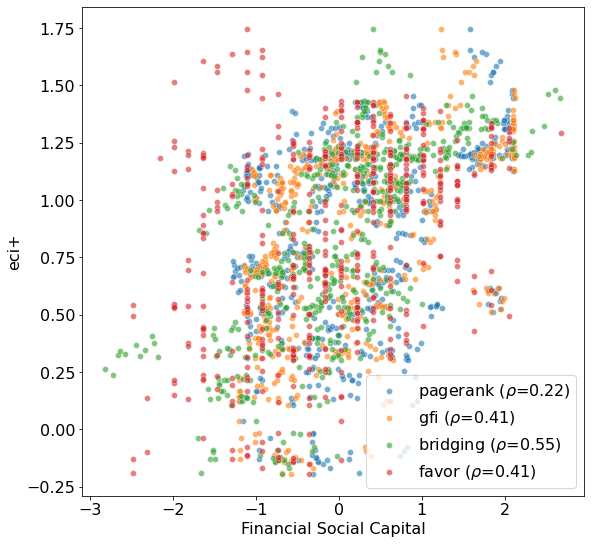

In [6]:
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(9,9))

for c in centralities:
    sns.scatterplot(df['financial_'+c], 
                y = df['eci+'], 
                ax=ax, 
                label = c, 
                alpha = 0.6)
    
plt.xlabel('Financial Social Capital')
plt.legend()


leg = ax.get_legend()
L_labels = leg.get_texts()
for i, l in enumerate(L_labels):
    centrality = l.get_text()
    corr = pearsonr(df['eci'], df['financial_' + centrality])[0]
    text = centrality + f' ($\\rho$={round(corr,2)})'
    L_labels[i].set_text(text)
    
save_to = os.path.join(Path(output_filepath).parent.parent.resolve(), 'reports', 'figures', 'financial_social_capital_vs_eci.png')
plt.savefig(save_to)    
plt.show()

In [7]:
df_correlations = pd.DataFrame({'centrality':centralities})

df_correlations['eci pearson'], df_correlations['eci p-value pearsonr'] = zip(*df_correlations.centrality.map(lambda x: pearsonr(df['eci'], df['financial_'+x])))
df_correlations['eci spearman'], df_correlations['eci p-value spearman'] = zip(*df_correlations.centrality.map(lambda x: spearmanr(df['eci'], df['financial_'+x])))

df_correlations['eci+ pearson'], df_correlations['eci+ p-value pearsonr'] = zip(*df_correlations.centrality.map(lambda x: pearsonr(df['eci+'], df['financial_'+x])))
df_correlations['eci+ spearman'], df_correlations['eci+ p-value spearman'] = zip(*df_correlations.centrality.map(lambda x: spearmanr(df['eci+'], df['financial_'+x])))

df_correlations

,centrality,eci pearson,eci p-value pearsonr,eci spearman,eci p-value spearman,eci+ pearson,eci+ p-value pearsonr,eci+ spearman,eci+ p-value spearman
0,pagerank,0.217882,4.401219e-07,0.177181,4.310110e-05,0.337008,1.836054e-15,0.328968,9.133898e-15
1,gfi,0.409857,9.115722e-23,0.409166,1.091450e-22,0.548740,9.051904e-43,0.577991,2.676320e-48
2,bridging,0.546123,2.662339e-42,0.576316,5.743769e-48,0.654045,1.219662e-65,0.697656,4.617803e-78
3,favor,0.409038,1.128288e-22,0.450904,9.381398e-28,0.378493,2.148318e-19,0.378352,2.220608e-19


In [8]:
df.columns

Index(['country', 'year', 'gini', 'population', 'pctg', 'wkn_population',
       'log_population', 'log_wkn_population', 'lag_log_population',
       'delta_log_population', 'lag_log_wkn_population',
       'delta_log_wkn_population', 'financial_authorities', 'financial_hubs',
       'financial_pagerank', 'financial_betweenness_centrality',
       'financial_gfi', 'financial_bridging', 'financial_favor',
       'financial_hhi', 'human_authorities', 'human_hubs', 'human_pagerank',
       'human_betweenness_centrality', 'human_gfi', 'human_bridging',
       'human_favor', 'human_hhi', 'output', 'gdp', 'log_output', 'log_gdp',
       'lag_financial_authorities', 'delta_financial_authorities',
       'per_change_financial_authorities', 'lag_financial_hubs',
       'delta_financial_hubs', 'per_change_financial_hubs',
       'lag_financial_pagerank', 'delta_financial_pagerank',
       'per_change_financial_pagerank', 'lag_financial_betweenness_centrality',
       'delta_financial_betweenness

In [9]:
f = 'eci ~ financial_pagerank + financial_gfi + financial_bridging + financial_favor + 1'
y, X = patsy.dmatrices(f, df.set_index(['country','year']),  return_type='dataframe')

model = PooledOLS(y,X)
pooled_res = model.fit()

pooled_res

Dep. Variable:,eci,R-squared:,0.4058
Estimator:,PooledOLS,R-squared (Between):,0.4374
No. Observations:,527,R-squared (Within):,-0.2880
Date:,"Thu, Nov 19 2020",R-squared (Overall):,0.4058
Time:,17:26:53,Log-likelihood,-417.18
Cov. Estimator:,Unadjusted,,
,,F-statistic:,89.118
Entities:,48,P-value,0.0000
Avg Obs:,10.979,Distribution:,"F(4,522)"
Min Obs:,10.0000,,
Max Obs:,11.000,F-statistic (robust):,89.118
